In [11]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [10]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-9p354co9
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-9p354co9
  Resolved https://github.com/pydata/xarray.git to commit 326dbe78d7ea887c2c242e811b7973661137617f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [12]:
import bambi as bmb

In this project I will be using **a combination of variables such as rating, year released, budget, runtime, and gross revenue to predict a movies popularity score out of 10**.

**Data**

In [5]:
movies = pd.read_csv('https://raw.githubusercontent.com/ThomasFurtado/Movies-Dataset-IMDb/refs/heads/main/movies.csv')
movies

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,More to Life,NaN,Drama,2020,"October 23, 2020 (United States)",3.1,18.0,Joseph Ebanks,Joseph Ebanks,Shannon Bond,United States,7000.0,NaN,NaN,90.0
7664,Dream Round,NaN,Comedy,2020,"February 7, 2020 (United States)",4.7,36.0,Dusty Dukatz,Lisa Huston,Michael Saquella,United States,NaN,NaN,Cactus Blue Entertainment,90.0
7665,Saving Mbango,NaN,Drama,2020,"April 27, 2020 (Cameroon)",5.7,29.0,Nkanya Nkwai,Lynno Lovert,Onyama Laura,United States,58750.0,NaN,Embi Productions,NaN
7666,It's Just Us,NaN,Drama,2020,"October 1, 2020 (United States)",NaN,NaN,James Randall,James Randall,Christina Roz,United States,15000.0,NaN,NaN,120.0


This is a really good data set, but I need to do some filtering first to prevent any errors further down the road.

In [38]:
# Getting rid of empty cells
movies.dropna(inplace=True)
# Taking these ratings only to prevent any weird outliers (eg. NC-17, M, GP, etc.)
movies= movies.query("rating in ['R','PG-13','PG','G']")
# I wanted the data to consist of english movies
movies= movies.query("country in ['United States','United Kingdom']")
# I took only the movies from the year 2000 and onwards because i wanted to reduce the number of ddata points slightly
movies= movies.query('year > 2000')

movies

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
3843,Harry Potter and the Sorcerer's Stone,PG,Adventure,2001,"November 16, 2001 (United States)",7.6,685000.0,Chris Columbus,J.K. Rowling,Daniel Radcliffe,United Kingdom,125000000.0,1.006968e+09,Warner Bros.,152.0
3844,The Fast and the Furious,PG-13,Action,2001,"June 22, 2001 (United States)",6.8,362000.0,Rob Cohen,Ken Li,Vin Diesel,United States,38000000.0,2.073055e+08,Universal Pictures,106.0
3846,Legally Blonde,PG-13,Comedy,2001,"July 13, 2001 (United States)",6.3,195000.0,Robert Luketic,Amanda Brown,Reese Witherspoon,United States,18000000.0,1.417747e+08,Metro-Goldwyn-Mayer (MGM),96.0
3848,"Monsters, Inc.",G,Animation,2001,"November 2, 2001 (United States)",8.1,838000.0,Pete Docter,Pete Docter,Billy Crystal,United States,115000000.0,5.797077e+08,Pixar Animation Studios,92.0
3850,Donnie Darko,R,Drama,2001,"January 19, 2001 (Mexico)",8.0,755000.0,Richard Kelly,Richard Kelly,Jake Gyllenhaal,United States,6000000.0,6.981586e+06,Pandora Cinema,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7643,Tenet,PG-13,Action,2020,"September 3, 2020 (United States)",7.4,387000.0,Christopher Nolan,Christopher Nolan,John David Washington,United States,205000000.0,3.636566e+08,Warner Bros.,150.0
7645,Birds of Prey,R,Action,2020,"February 7, 2020 (United States)",6.1,190000.0,Cathy Yan,Christina Hodson,Margot Robbie,United States,84500000.0,2.018585e+08,Clubhouse Pictures (II),109.0
7648,Bad Boys for Life,R,Action,2020,"January 17, 2020 (United States)",6.6,140000.0,Adil El Arbi,Peter Craig,Will Smith,United States,90000000.0,4.265052e+08,Columbia Pictures,124.0
7649,Sonic the Hedgehog,PG,Action,2020,"February 14, 2020 (United States)",6.5,102000.0,Jeff Fowler,Pat Casey,Ben Schwartz,United States,85000000.0,3.197157e+08,Paramount Pictures,99.0


**Priors**

There was an issue with my models in the fact that they didn't know where to start in terms of identifying a pattern/distribution, so I had to go in and hand define all the numerical predictors priors which is what you see below. These are not very thought out/ informed since I still wanted my actual model to do most of the work,but they do their job as a starting point.

In [39]:
priors = {"budget" : bmb.Prior("Normal", mu=80000000,sigma=10000), "alpha" : bmb.Prior("HalfNormal",sigma=10),
         "gross": bmb.Prior("Normal", mu=1000000000,sigma=100000), "alpha" : bmb.Prior("HalfNormal",sigma=10),
         "runtime": bmb.Prior("Normal", mu=100,sigma=50), "alpha" : bmb.Prior("HalfNormal",sigma=10),
         "year": bmb.Prior("Normal", mu=2010,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}

**Version O**

This model is basically my prediction of what I think should be the best combination of predictors.

My logic with the heirarchy between budget and gross revenue is that the higher the budget, the higher the revenue. Theoretically, the higher the budget, the better the actors and special effects/production. Good acting and good production makes good movies, and good movies make good money.

I also added an interatction between year released and budget. Cinema has been a rapidly growing industry with a yearly growth rate of around 4.6% per year (according to [Satistica](https://www.statista.com/outlook/amo/media/cinema/worldwide#:~:text=in%20the%20world%2C%20revenue%20in,1.9bn%20users%20by%202029.)). The estimated value of the sector is about $87 billion as of 2023. Using this information I decided to assume that the year of production would have an effect on the budget (albeit a weak one).

**Initial Causal Diagram**

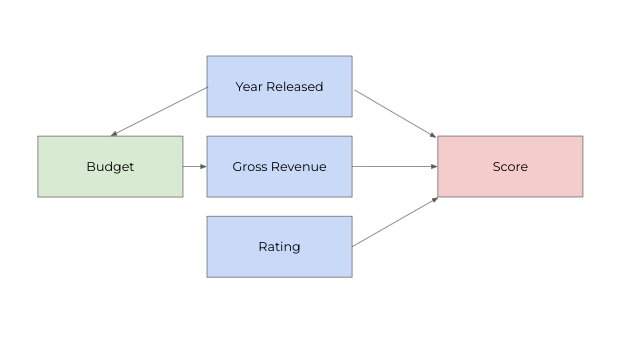

In [40]:
model_v0 = bmb.Model("score ~ year + budget|gross + rating + year:budget", data=movies, priors=priors)
#fit the model
idata_v0 = model_v0.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

**Version 1**

For my first variation I just wanted to start basic. I used all of my predictors but did't add any fancy heirarchies or interactions or anything. I added runtimme in even though it wasnt in my ideal model (v0) beause I thought it would be good to include it going forward just in case it does have an effect (I don't think it will).

In [41]:
model_v1 = bmb.Model("score ~ year + budget + gross + runtime + rating", data=movies, priors=priors)
#fit the model
idata_v1 = model_v1.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

**Version 2**

For this model I decided to scrap the year to budget interaction and only include the budget to gross revenue heirarchy. I did this because I wanted to isolate my connection in seperate models to see if either performed better individually.

In [42]:
model_v2 = bmb.Model("score ~ year + runtime + rating + budget|gross", data=movies, priors=priors)
#fit the model
idata_v2 = model_v2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

**Version 3**

Similiarly to version 2, in version 3 I only included my interaction between year and budget just to see if it persormed better without the added heirarchy

In [43]:
model_v3 = bmb.Model("score ~ gross + runtime + rating + year:budget", data=movies, priors=priors)
#fit the model
idata_v3 = model_v3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Version 4**

For this version I just switched the heirarchy to a interaction and the interaction to a heirarchy. I did this since I could see the logic for both ways and wanted to see if there was a significant difference in doing so, but also just for fun.

In [17]:
model_v4 = bmb.Model("score ~ year + budget + gross + runtime + rating + year|budget + budget:gross", data=movies, priors=priors)
#fit the model
idata_v4 = model_v4.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

**Version 5**

For this version I kept everything from version 4, but decided to cut runtime as a predictor. After consideration I decided that runtime is defenitley not a huge factor in whether or not people watch a movie or not and even less of a factor when they rate it out of ten.

In [18]:
model_v5 = bmb.Model("score ~ year + budget + gross + rating + year|budget + budget:gross", data=movies, priors=priors)
#fit the model
idata_v5 = model_v5.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

**Version 6**

Just as a sort of control/baseline for my other models, I decided to run one with all my predictors "plain" but without runtime to see if it really even had a significant effect (spoiler alert, it didn't).

In [19]:
model_v6 = bmb.Model("score ~ year + budget + gross + rating", data=movies, priors=priors)
#fit the model
idata_v6 = model_v6.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

**Comparision**

I am comparing all my models here to see whcih one is the best.

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

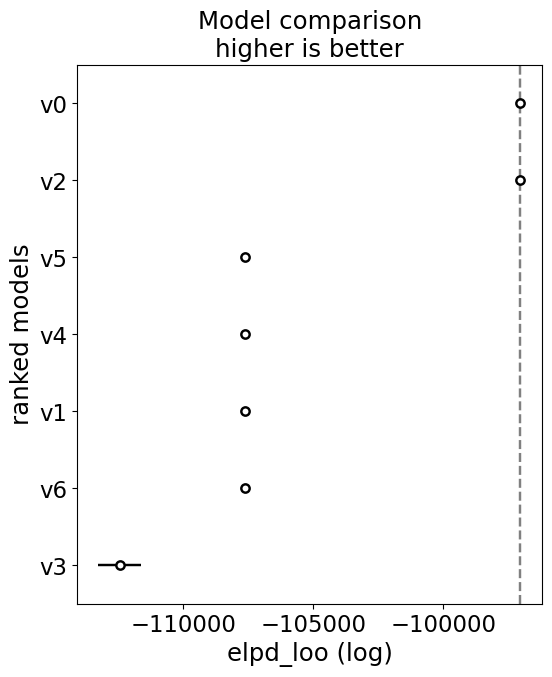

In [23]:
cmp_1 = az.compare( {"v0":idata_v0, "v1":idata_v1,"v2":idata_v2, "v3":idata_v3, "v4":idata_v4, "v5":idata_v5, "v6":idata_v6} )
cmp_1
az.plot_compare(cmp_1)

In [29]:
cmp_1

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
v0,0,-97065.164695,2.736686,0.000000,9.999948e-01,61.399882,0.000000,False,log
v2,1,-97065.331485,2.981640,0.166790,5.231329e-06,61.378703,0.023621,False,log
v5,2,-107618.058916,12.181320,10552.894221,4.082429e-09,129.094291,104.609113,False,log
v4,3,-107618.215364,11.955325,10553.050669,4.082173e-09,129.113366,104.632690,False,log
v1,4,-107618.376367,12.626799,10553.211672,4.077309e-09,129.308910,104.800200,False,log
v6,5,-107618.758880,12.755290,10553.594185,4.074772e-09,129.458366,104.953124,False,log
v3,6,-112441.026165,4915.672139,15375.861470,2.339304e-09,819.046087,785.118716,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

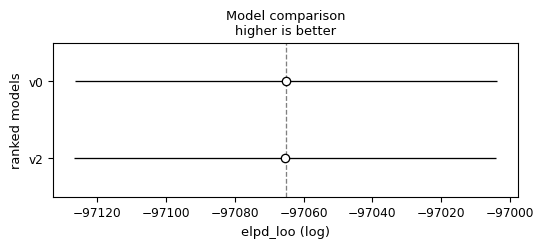

In [26]:
cmp_2 = az.compare( {"v0":idata_v0, "v2":idata_v2} )
cmp_2
az.plot_compare(cmp_2)

Yay! My predicted model (v0) did the best! Considering the very very marginal difference between v0 and v2, I'm guessing that the heirarchy between budget and gross revenue was very significant to their sucess. The only difference between them is that v2 included runtime as a predictor which, as I suspected, didn't seem to have much of an impact at all.

Another interesting thing worth noticing is how the models seem to be "grouped" into individual eldp_loo values. For example, the eldp_loo values for v1 and v2 have a difference of less than 1 between them. Same with v5 and v4 as well as v1 and v6. However, v3 seems to be an outlier, performing abysmally in comparison to the others.

**Final Causal Diagram**

It's the same as beofre becuase my predicted model ended up being the best!
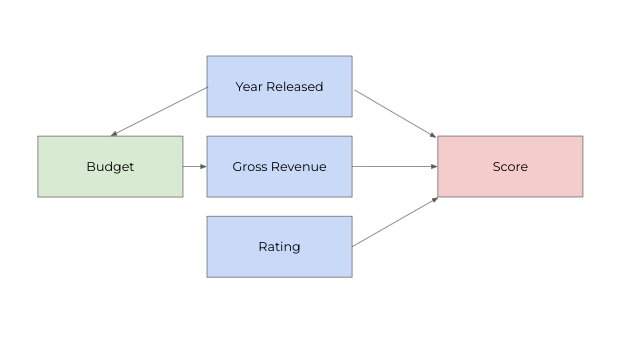

**References**

Research- https://www.statista.com/outlook/amo/media/cinema/worldwide#:~:text=in%20the%20world%2C%20revenue%20in,1.9bn%20users%20by%202029.

Data- https://raw.githubusercontent.com/ThomasFurtado/Movies-Dataset-IMDb/refs/heads/main/movies.csv

